In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-01-06 07:10:55--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-01-06 07:10:55 (34.8 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 57.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm

In [4]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df['LogPassengers'] = np.log(df['Passengers'])

In [6]:
Ntest=12
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

### Auto ARIMA

Automatically finds the best models. Auto ARIMA tries several different settings and returns the best.

AIC and BIC
http://www.differencebetween.net/miscellaneous/difference-between-aic-and-bic/

In [7]:
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

model = pm.auto_arima(train['Passengers'],
                      trace=True, # to see which model tested out by Auto ARIMA
                      supress_warnings=True,
                      seasonal=True, m=12) # to fit full seasonal ARIMA model on 12 seasonal period

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.41 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.32 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.59 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.15 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.44 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Thu, 06 Jan 2022   AIC                            905.686
Time:                                    07:13:22   BIC                            919.623
Sample:                                         0   HQIC                           911.346
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

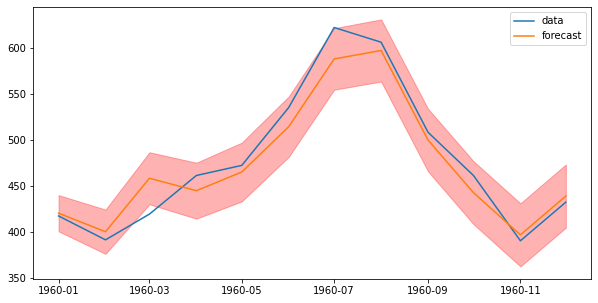

In [10]:
# Plotting forecast with true label

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['Passengers'], label='data') # plot test data
ax.plot(test.index, test_pred, label='forecast') # plot test prediction
ax.fill_between(test.index, confint[:,0], confint[:,1],
                color = 'red', alpha = 0.3) # plot confidence bounds

ax.legend();

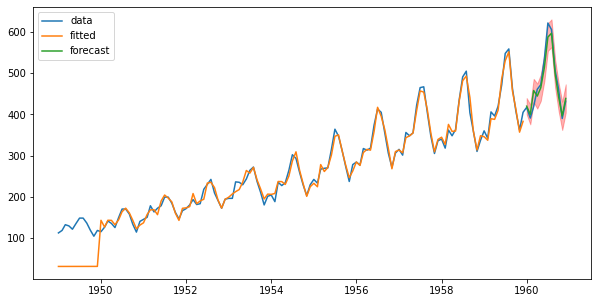

In [13]:
train_pred = model.predict_in_sample(start=0, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['Passengers'], label='data') # plot test data
ax.plot(train.index, train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast') # plot test prediction
ax.fill_between(test.index, confint[:,0], confint[:,1],
                color = 'red', alpha = 0.3) # plot confidence bounds

ax.legend();

#### Try On Logged Data

In [14]:
logmodel = pm.auto_arima(train['LogPassengers'],
                         trace = True,
                         surpress_warnings = True,
                         seasonal = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-440.663, Time=2.59 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-317.949, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-433.027, Time=1.69 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-383.189, Time=0.62 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-134.983, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-444.326, Time=2.03 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-414.783, Time=1.04 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-442.329, Time=5.33 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-436.716, Time=1.95 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=inf, Time=5.14 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-445.502, Time=1.84 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-414.732, Time=0.54 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-441.068, Time=2.07 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-443.512, Time=7.37 sec
 ARIMA(1,0,2)(1,1,0)[12]

In [15]:
logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 229.026
Date:                              Thu, 06 Jan 2022   AIC                           -448.052
Time:                                      07:22:27   BIC                           -434.114
Sample:                                           0   HQIC                          -442.392
                                              - 132                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0193      0.009      2.155      0.031       0.002       0.037
ar.L1          0.5997      0.083      7.263      0.000       0.438       0.762
ar.L2          0.2422      0.085      2.858      0.004       0.076       0.408
ma.S.L12      -0.5683      0.105     -5.436      0.000      -0.773      -0.363
sigma2         0.0012      0.000      8.194      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.07
Prob(Q):                              1.00   Prob(JB):                         0.05
Heteroskedasticity (H):               0.36   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

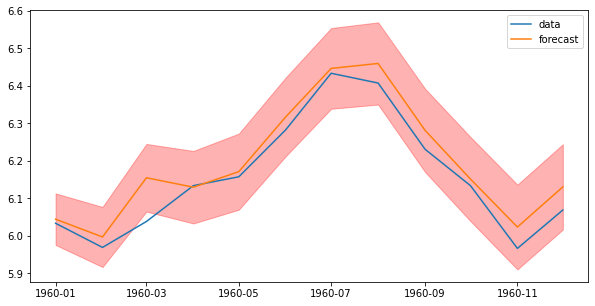

In [16]:
test_pred_log, confint = logmodel.predict(n_periods=Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['LogPassengers'], label='data')
ax.plot(test.index, test_pred_log, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1],
                color = 'red', alpha = 0.3)

ax.legend();

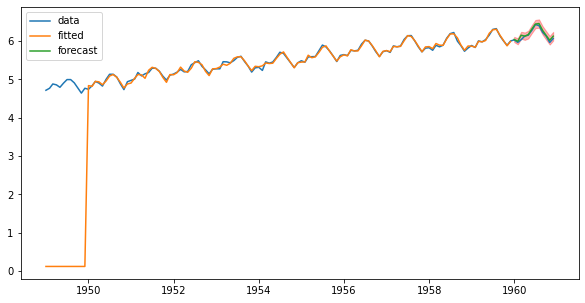

In [17]:
train_pred_log = logmodel.predict_in_sample(start=0, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['LogPassengers'], label='data')
ax.plot(train.index, train_pred_log, label='fitted')
ax.plot(test.index, test_pred_log, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1],
                color = 'red', alpha = 0.3)

ax.legend();

In [18]:
# RMSE

def rmse(t, y):
  return np.sqrt(np.mean((t - y)**2))

In [19]:
print("Non-Logged RMSE:", rmse(test['Passengers'], test_pred))
print("Logged RMSE:", rmse(test['Passengers'], np.exp(test_pred_log)))

Non-Logged RMSE: 18.536468964799457
Logged RMSE: 23.051734622075276


In [23]:
# Non Seasonal

# The stepwise algorithm can be significantly faster than fitting all 
# (or a random subset of) hyper-parameter combinations and is less likely 
# to over-fit the model.
# Default = True

model = pm.auto_arima(train['LogPassengers'],
                      trace = True,
                      surpress_warnings = True,
                      max_p = 12, max_q = 2, max_order = 14,
                      stepwise = True,
                      seasonal = False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-211.983, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-214.718, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-216.493, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-212.867, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-221.069, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-216.622, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-222.099, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-217.708, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-215.917, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-228.902, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-217.540, T

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(4, 1, 2)   Log Likelihood                 133.478
Date:                Thu, 06 Jan 2022   AIC                           -250.956
Time:                        07:31:50   BIC                           -227.955
Sample:                             0   HQIC                          -241.610
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0102      0.002      5.365      0.000       0.006       0.014
ar.L1          0.0419      0.121      0.346      0.729      -0.196       0.279
ar.L2          0.4491      0.115      3.895      0.000       0.223       0.675
ar.L3         -0.2337      0.099     -2.369      0.018      -0.427      -0.040
ar.L4         -0.2501      0.106     -2.354      0.019      -0.458      -0.042
ma.L1         -0.0467      0.078     -0.597      0.551      -0.200       0.107
ma.L2         -0.8622      0.076    -11.276      0.000      -1.012      -0.712
sigma2         0.0075      0.001      5.522      0.000       0.005       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.70
Prob(Q):                              0.96   Prob(JB):                         0.06
Heteroskedasticity (H):               1.03   Skew:                             0.23
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

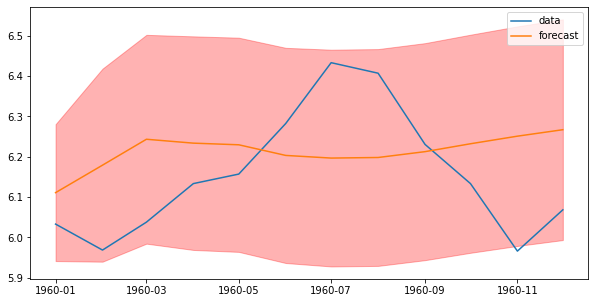

In [25]:
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['LogPassengers'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1],
                color = 'red', alpha = 0.3)

ax.legend();

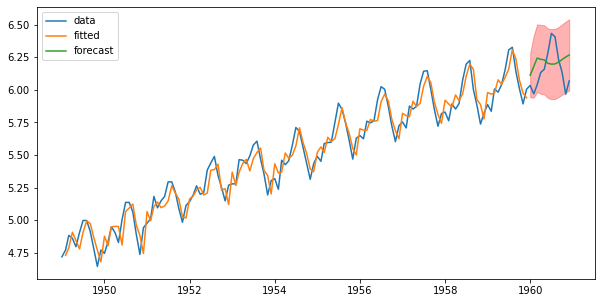

In [28]:
train_pred = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['LogPassengers'], label='data')
ax.plot(train.index[1:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1],
                color = 'red', alpha = 0.3)

ax.legend();

In [30]:
rmse(test['Passengers'], np.exp(test_pred))

82.64817323527205

#### Full Grid Search

In [31]:
model = pm.auto_arima(train['LogPassengers'],
                      trace = True,
                      surpress_warnings = True,
                      max_p = 12, max_q = 2, max_order = 14,
                      stepwise = False,
                      seasonal = False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-211.983, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-216.493, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-214.718, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-221.069, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-216.622, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-216.024, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-246.300, Time=0.44 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-229.057, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-227.139, Time=0.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-250.956, Time=0.61 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept  

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:              SARIMAX(12, 1, 1)   Log Likelihood                 227.055
Date:                Thu, 06 Jan 2022   AIC                           -424.111
Time:                        07:34:42   BIC                           -380.983
Sample:                             0   HQIC                          -406.586
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0067      0.006      1.135      0.256      -0.005       0.018
ar.L1          0.0313      0.090      0.345      0.730      -0.146       0.209
ar.L2         -0.0725      0.070     -1.042      0.297      -0.209       0.064
ar.L3         -0.0440      0.067     -0.657      0.511      -0.175       0.087
ar.L4         -0.1116      0.073     -1.533      0.125      -0.254       0.031
ar.L5          0.0144      0.066      0.218      0.827      -0.115       0.144
ar.L6         -0.0607      0.067     -0.904      0.366      -0.192       0.071
ar.L7         -0.0549      0.073     -0.748      0.455      -0.199       0.089
ar.L8         -0.1148      0.068     -1.693      0.091      -0.248       0.018
ar.L9          0.0115      0.078      0.148      0.883      -0.141       0.164
ar.L10        -0.0837      0.066     -1.265      0.206      -0.213       0.046
ar.L11         0.0044      0.073      0.060      0.952      -0.138       0.147
ar.L12         0.7920      0.064     12.468      0.000       0.667       0.916
ma.L1         -0.3414      0.128     -2.659      0.008      -0.593      -0.090
sigma2         0.0016      0.000      6.989      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.79   Prob(JB):                         0.28
Heteroskedasticity (H):               0.36   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

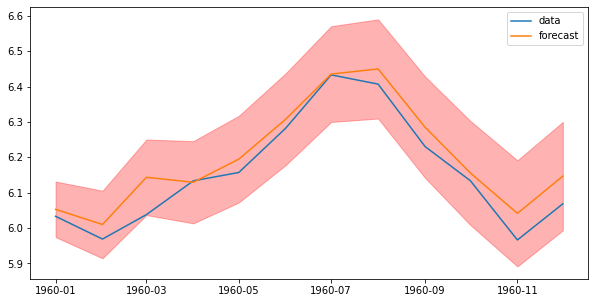

In [33]:
test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['LogPassengers'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1],
                color = 'red', alpha = 0.3)

ax.legend();

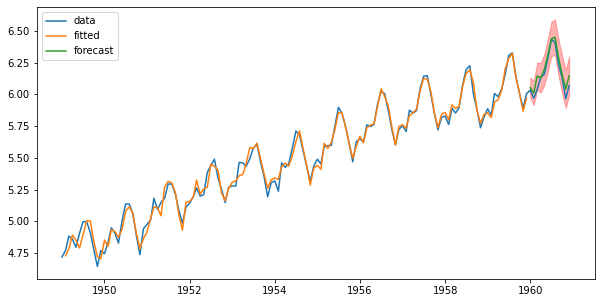

In [34]:
train_pred = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['LogPassengers'], label='data')
ax.plot(train.index[1:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1],
                color = 'red', alpha = 0.3)

ax.legend();

In [35]:
rmse(test['Passengers'], np.exp(test_pred))

23.84864030869433